<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmointGen_Norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Data/Tweets_clean_data.csv')
df = df.sample(frac=1,random_state=32)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/device:GPU:0


In [2]:
category_dict = {"anger":[1,0,0,0],"sadness":[0,1,0,0],"fear":[0,0,1,0],"joy":[0,0,0,1]}
data_tweet = [x.lower().split() for x in df['Tweet']]
data_cat = np.array([category_dict[x] for x in df['Emotion']])

In [3]:
print(data_tweet[:5])
print(data_cat[:5])

[['with', 'their', 'faggy', 'colors', 'are', 'nice', 'is', 'ok', 'too', 'even', 'tho', 'some', 'might', 'take', 'offense', 'because', 'words', 'lol'], ['unbelievable', 'takes', '10', 'minutes', 'to', 'get', 'through', 'to', 'then', 'there', 'is', 'a', 'fault', 'and', 'the', 'call', 'hangs', 'up', 'treatcustomersfairly'], ['well', 'i', 'did', 'hear', 'once', 'before', 'that', 'girls', 'are', 'attracted', 'to', 'men', 'that', 'lok', 'like', 'their', 'dad', 'ok', 'hand'], ['agreed', 'so', 'tired', 'of', 'this', 'nonsense', 'soros', 'must', 'be', 'elated'], ['by', 'the', 'way', 'i', 'am', 'wearing', 'the', 'smile', 'you', 'gave', 'me', 'today', 'n', 'you', 'me']]
[[1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]]


In [4]:
# Parameters
Min_count = 0
Embedding_size = 200
Window_size = 5
Negative_sampling = 00

In [5]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [6]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.200d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [7]:
print(len(vocab_sg))
print(len(vocab_cbow))


13658
13658


In [8]:
batch_size = 100
Max_input_size = max([len(x) for x in data_tweet])


In [9]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([w2v.wv.get_vector(i) for i in x if i in vocab]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([vocab[i] for i in x if i in vocab.keys()]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_tweet, data_cat, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
result_table = [0,0,0,0,0,0,0,0,0]

In [11]:
epochs = 60

In [12]:
from keras import backend as K
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recalls = true_positives / (possible_positives + K.epsilon())
        return recalls
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precisions = true_positives / (predicted_positives + K.epsilon())
        return precisions
def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [13]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(64))
model_sg.add(tf.keras.layers.Dropout(0.2))
model_sg.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg.add(tf.keras.layers.Dropout(0.2))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
sg_train_gen=vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size)
sg_val_gen=vec_gen(w2v_sg,vocab_sg,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_sg_lstm = model_sg.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 9s 133ms/step - loss: 1.3819 - accuracy: 0.2974 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3728 - val_accuracy: 0.3300 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 113ms/step - loss: 1.3783 - accuracy: 0.3054 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3695 - val_accuracy: 0.3367 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 5s 113ms/step - loss: 1.3759 - accuracy: 0.3105 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3709 - val_accuracy: 0.3333 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
46/46 [==============================] - 5s 113ms/step - loss: 1.3758 - accuracy: 0.3163 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - va

In [14]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_sg_bi = model_sg_bi.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 10s 141ms/step - loss: 1.3818 - accuracy: 0.2805 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3663 - val_accuracy: 0.3292 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 121ms/step - loss: 1.3649 - accuracy: 0.3184 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3492 - val_accuracy: 0.3675 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 6s 122ms/step - loss: 1.3245 - accuracy: 0.3743 - f1: 0.0029 - precision: 0.0640 - recall: 0.0015 - val_loss: 1.3173 - val_accuracy: 0.3892 - val_f1: 0.0840 - val_precision: 0.5328 - val_recall: 0.0458
Epoch 4/60
46/46 [==============================] - 6s 122ms/step - loss: 1.2471 - accuracy: 0.4520 - f1: 0.1397 - precision: 0.6936 - recall: 0.0802 - val_loss: 1.3430 - val_accuracy: 0.39

In [15]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(64))
model_sg_rnn.add(tf.keras.layers.Dropout(0.2))
model_sg_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_rnn.add(tf.keras.layers.Dropout(0.2))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_sg_rnn = model_sg_rnn.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)


result_table[2]=history[1]
print("SG_RNN")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 8s 154ms/step - loss: 1.3870 - accuracy: 0.2650 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3712 - val_accuracy: 0.3333 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 7s 146ms/step - loss: 1.3768 - accuracy: 0.3036 - f1: 1.8318e-05 - precision: 9.2507e-04 - recall: 9.2507e-06 - val_loss: 1.3826 - val_accuracy: 0.3067 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 7s 145ms/step - loss: 1.3800 - accuracy: 0.2923 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3687 - val_accuracy: 0.3325 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
46/46 [==============================] - 7s 144ms/step - loss: 1.3819 - accuracy: 0.3017 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - va

In [16]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(64))
model_cbow.add(tf.keras.layers.Dropout(0.2))
model_cbow.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow.add(tf.keras.layers.Dropout(0.2))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
cbow_train_gen=vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size)
cbow_val_gen=vec_gen(w2v_cbow,vocab_cbow,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_cbow_lstm = model_cbow.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 8s 129ms/step - loss: 1.3817 - accuracy: 0.2974 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3725 - val_accuracy: 0.3300 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 113ms/step - loss: 1.3792 - accuracy: 0.3054 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3704 - val_accuracy: 0.3367 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 5s 113ms/step - loss: 1.3774 - accuracy: 0.3105 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3703 - val_accuracy: 0.3333 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
46/46 [==============================] - 5s 113ms/step - loss: 1.3747 - accuracy: 0.3164 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - va

In [17]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_cbow_bi = model_cbow_bi.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 10s 139ms/step - loss: 1.3810 - accuracy: 0.2923 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3638 - val_accuracy: 0.3292 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 119ms/step - loss: 1.3598 - accuracy: 0.3248 - f1: 4.5999e-05 - precision: 0.0023 - recall: 2.3230e-05 - val_loss: 1.3307 - val_accuracy: 0.3792 - val_f1: 0.0033 - val_precision: 0.1667 - val_recall: 0.0017
Epoch 3/60
46/46 [==============================] - 5s 120ms/step - loss: 1.3095 - accuracy: 0.3857 - f1: 0.0449 - precision: 0.6210 - recall: 0.0240 - val_loss: 1.2958 - val_accuracy: 0.3967 - val_f1: 0.0858 - val_precision: 0.5664 - val_recall: 0.0467
Epoch 4/60
46/46 [==============================] - 6s 122ms/step - loss: 1.2435 - accuracy: 0.4429 - f1: 0.1654 - precision: 0.6726 - recall: 0.0959 - val_loss: 1.2835 - val_accuracy: 0.3950 - val_f1: 0.1

In [18]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(64))
model_cbow_rnn.add(tf.keras.layers.Dropout(0.2))
model_cbow_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_rnn.add(tf.keras.layers.Dropout(0.2))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])

history_cbow_rnn = model_cbow_rnn.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 8s 154ms/step - loss: 1.3914 - accuracy: 0.2743 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3731 - val_accuracy: 0.3300 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 7s 144ms/step - loss: 1.3768 - accuracy: 0.2963 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3647 - val_accuracy: 0.3267 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 7s 145ms/step - loss: 1.3608 - accuracy: 0.3302 - f1: 7.0338e-04 - precision: 0.0355 - recall: 3.5521e-04 - val_loss: 1.3446 - val_accuracy: 0.3600 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
46/46 [==============================] - 7s 145ms/step - loss: 1.3458 - accuracy: 0.3497 - f1: 0.0172 - precision: 0.2762 - recall: 0.0093 - val_loss: 1.3422 -

In [19]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove.add(tf.keras.layers.LSTM(64))
model_glove.add(tf.keras.layers.Dropout(0.2))
model_glove.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove.add(tf.keras.layers.Dropout(0.2))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
glove_train_gen=glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size)
glove_val_gen=glove_gen(vocab_glove,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_glove_lstm = model_glove.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/60
46/46 [==============================] - 4s 38ms/step - loss: 1.3820 - accuracy: 0.2913 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3720 - val_accuracy: 0.3325 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 1s 26ms/step - loss: 1.3291 - accuracy: 0.3559 - f1: 0.0844 - precision: 0.2532 - recall: 0.0528 - val_loss: 1.1898 - val_accuracy: 0.4617 - val_f1: 0.3739 - val_precision: 0.6162 - val_recall: 0.2692
Epoch 3/60
46/46 [==============================] - 1s 26ms/step - loss: 1.2015 - accuracy: 0.4562 - f1: 0.3352 - precision: 0.6341 - recall: 0.2421 - val_loss: 1.1461 - val_accuracy: 0.4733 - val_f1: 0.3943 - val_precision: 0.6470 - val_recall: 0.2842
Epoch 4/60
46/46 [==============================] - 1s 25ms/step - loss: 1.1196 - accuracy: 0.4835 - f1: 0.4075 - precision: 0.6926 - recall: 0.2908 - val_loss: 1.0920 - val_accuracy: 0.4975 - val_f1: 0.4215 - val_pre

In [20]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_glove_bi = model_glove_bi.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/60
46/46 [==============================] - 6s 63ms/step - loss: 1.3755 - accuracy: 0.3135 - f1: 5.0661e-04 - precision: 0.0144 - recall: 2.6090e-04 - val_loss: 1.2692 - val_accuracy: 0.4133 - val_f1: 0.0789 - val_precision: 0.8118 - val_recall: 0.0417
Epoch 2/60
46/46 [==============================] - 2s 41ms/step - loss: 1.2295 - accuracy: 0.4488 - f1: 0.1879 - precision: 0.6785 - recall: 0.1151 - val_loss: 1.1402 - val_accuracy: 0.5142 - val_f1: 0.3919 - val_precision: 0.6040 - val_recall: 0.2908
Epoch 3/60
46/46 [==============================] - 2s 40ms/step - loss: 1.0489 - accuracy: 0.5668 - f1: 0.4592 - precision: 0.6901 - recall: 0.3462 - val_loss: 1.0065 - val_accuracy: 0.5933 - val_f1: 0.5208 - val_precision: 0.6825 - val_recall: 0.4217
Epoch 4/60
46/46 [==============================] - 2s 40ms/step - loss: 0.8935 - accuracy: 0.6451 - f1: 0.5898 - precision: 0.7346 - recall: 0.4945 - val_loss: 0.9000 - val_accuracy: 0.6392 - val_f1: 0.5990 - val_precision: 0.7167 -

In [21]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(64))
model_glove_rnn.add(tf.keras.layers.Dropout(0.2))
model_glove_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_rnn.add(tf.keras.layers.Dropout(0.2))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_glove_rnn = model_glove_rnn.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


46/46 [==============================] - 5s 84ms/step - loss: 1.3864 - accuracy: 0.2606 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3659 - val_accuracy: 0.3317 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 3s 75ms/step - loss: 1.3799 - accuracy: 0.3014 - f1: 0.0018 - precision: 0.0747 - recall: 9.3571e-04 - val_loss: 1.3688 - val_accuracy: 0.3300 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 3s 74ms/step - loss: 1.3878 - accuracy: 0.2772 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3667 - val_accuracy: 0.3367 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
46/46 [==============================] - 3s 74ms/step - loss: 1.3762 - accuracy: 0.3083 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3673 - val_ac

	Lstm			BiLstm			Rnn
sg [0.4871428608894348, 0.5964285731315613, 0.28928571939468384]
cbow [0.49714285135269165, 0.602142870426178, 0.3442857265472412]
glove [0.802142858505249, 0.7878571152687073, 0.5071428418159485]
{'loss': [1.3783377408981323, 1.3613847494125366, 1.3077408075332642, 1.2208513021469116, 1.1554948091506958, 1.1048213243484497, 1.0709242820739746, 1.0345042943954468, 1.0128980875015259, 0.9775596261024475, 0.9548526406288147, 0.9357914328575134, 0.9308721423149109, 0.8856363296508789, 0.8606762886047363, 0.8119085431098938, 0.7764349579811096, 0.7502379417419434, 0.7323710918426514, 0.6955975890159607, 0.662286639213562, 0.6362349390983582, 0.6550601124763489, 0.5821753740310669, 0.5488330721855164, 0.5501968264579773, 0.49769100546836853, 0.495244562625885, 0.4580874741077423, 0.43802571296691895, 0.44183555245399475, 0.38913992047309875, 0.35995596647262573, 0.38384565711021423, 0.343825101852417, 0.3257773220539093, 0.3032320439815521, 0.271626353263855, 0.27126869

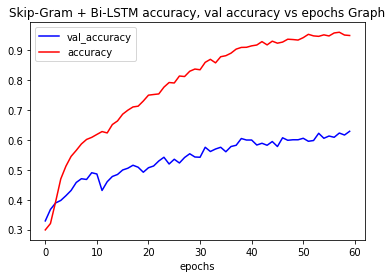

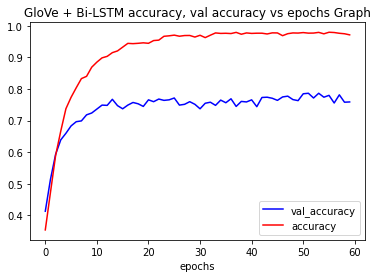

In [22]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_sg_bi.history['val_accuracy'],c='b',label='val_accuracy')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_glove_bi.history['val_accuracy'],c='b',label='val_accuracy')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()